In [46]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from sklearn.metrics import confusion_matrix
import numpy as np

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
df = pd.read_csv('/content/drive/MyDrive/Soft_Com/Assignment_3/Dataset_2.csv',encoding='latin1')
df = df.sample(frac=1).reset_index(drop=True)
df.sample(10)

,text,polarity
6395,@urbanfantasygrl Read both @katiemacalister 's...,0
5180,why's depression such a pain in the hole there...,1
5357,oooh! this is my 500th tweet so I shall have a...,0
4561,@Popehat @zentropy_ @JeremyRJenkins @marknutte...,1
4560,#BeingAdoptedMeans I have struggled with depre...,1
4844,I want to have a good time!,0
2793,You have everything you needwithin you to win ...,1
732,Dating Someone with Depression http://busines...,1
4917,"@SpiderxBear Friday sometime,lol. Wouldn't hav...",0
7429,"@consumingtheart No, Dusty! My furry kid",0


In [49]:
df.groupby('polarity').size()

polarity
0    8000
1    2314
dtype: int64

Text(0.5, 0, 'text')

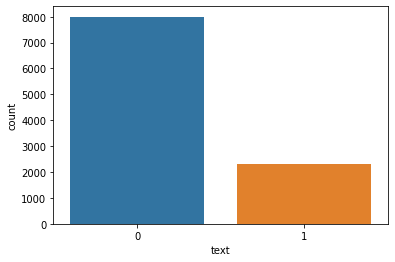

In [50]:

sns.countplot(df.polarity)
plt.xlabel('text')

In [51]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.text.tolist())
        self.labels = data.polarity.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [52]:
batch_size = 100

In [53]:
dataset = Sequences(df)
train_size = int(len(dataset)*.8);
test_size = int(len(dataset) - train_size);
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [54]:
len(dataset.token2idx)

22212

In [68]:
input_size = len(dataset.token2idx)
hidden_size = 128
num_classes = 2
num_layers = 3
learning_rate = 0.01
sequence_length = 1
num_epochs = 20

In [69]:
print(len(train_dataset))
print(len(test_dataset))

8251
2063


In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [71]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.D = 2
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(self.D*hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.D*self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, h0) 
        h0 = torch.zeros(self.D*self.num_layers, out.size(0), self.hidden_size).to(device) 
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [72]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [75]:
# Train the model
y_pred = []
y_test = []
iter = []
losses = []
itr = 0
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (tweets, labels) in enumerate(train_loader):
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        # Forward pass
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        itr = itr + 1
        if (i+1) % 10 == 0:
            iter.append(itr)
            losses.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for tweets, labels in test_loader:
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_test.extend(labels)

    print('Test Accuracy of the model : {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/20], Step [10/83], Loss: 0.0021
Epoch [1/20], Step [20/83], Loss: 0.0001
Epoch [1/20], Step [30/83], Loss: 0.0000
Epoch [1/20], Step [40/83], Loss: 0.0000
Epoch [1/20], Step [50/83], Loss: 0.0000
Epoch [1/20], Step [60/83], Loss: 0.0002
Epoch [1/20], Step [70/83], Loss: 0.0003
Epoch [1/20], Step [80/83], Loss: 0.0003
Epoch [2/20], Step [10/83], Loss: 0.0003
Epoch [2/20], Step [20/83], Loss: 0.0026
Epoch [2/20], Step [30/83], Loss: 0.0000
Epoch [2/20], Step [40/83], Loss: 0.0000
Epoch [2/20], Step [50/83], Loss: 0.0000
Epoch [2/20], Step [60/83], Loss: 0.0000
Epoch [2/20], Step [70/83], Loss: 0.0000
Epoch [2/20], Step [80/83], Loss: 0.0021
Epoch [3/20], Step [10/83], Loss: 0.0003
Epoch [3/20], Step [20/83], Loss: 0.0003
Epoch [3/20], Step [30/83], Loss: 0.0000
Epoch [3/20], Step [40/83], Loss: 0.0000
Epoch [3/20], Step [50/83], Loss: 0.0000
Epoch [3/20], Step [60/83], Loss: 0.0000
Epoch [3/20], Step [70/83], Loss: 0.0000
Epoch [3/20], Step [80/83], Loss: 0.0004
Epoch [4/20], St

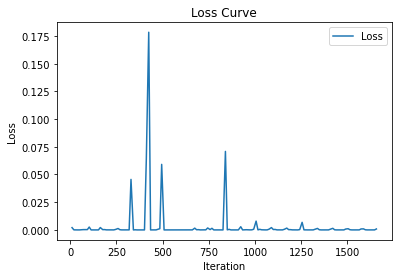

In [77]:
plt.plot(iter, losses, label='Loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

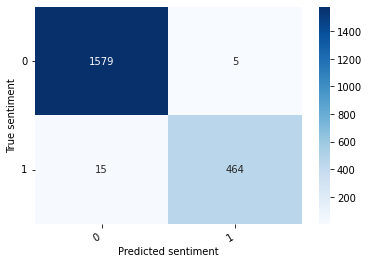

In [78]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])
show_confusion_matrix(df_cm)


In [79]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y_test)):
  tn += ((y_pred[i] == 0) &  (y_test[i] == 0)).float()
  tp += ((y_pred[i] == 1) &  (y_test[i] == 1)).float()
  fn += ((y_pred[i] == 0) &  (y_test[i] == 1)).float()
  fp += ((y_pred[i] == 1) &  (y_test[i] == 0)).float()

print(tn, ' ', fn, ' ', fp, ' ', tp)

tensor(1579.)   tensor(15.)   tensor(5.)   tensor(464.)


In [80]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2* ((precision*recall)/(precision+recall))

In [81]:
print('Precision: ', precision.item(), 'Recall: ', recall.item(),  'F1_score: ', f1_score.item())

Precision:  0.9893389940261841 Recall:  0.968684732913971 F1_score:  0.9789028763771057


In [82]:
def table(l1, columns):
  plt.rcParams["figure.figsize"] = [10, 2]
  plt.rcParams["figure.autolayout"] = True
  
  fig, axs = plt.subplots(1, 1)
  data = np.column_stack(l1)
  axs.axis('tight')
  axs.axis('off')
  the_table = axs.table(cellText=data, colLabels=columns, loc='center', cellLoc = 'center')
  the_table.auto_set_font_size(False)
  the_table.set_fontsize(18)
  the_table.scale(1.5, 1.5)
  plt.show()